# Churn Customer Classification

## Import Necessary Library

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## Download & Import Dataset

In [98]:
# Download dataset (don't run if data exist)
url = "https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco_final.csv"
dataset_dir = "./dataset/churn_telco.csv"
!curl $url --output $dataset_dir 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  446k  100  446k    0     0   903k      0 --:--:-- --:--:-- --:--:--  905k


In [99]:
# Import dataset
telco_churn_df = pd.read_csv(dataset_dir)
telco_churn_df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


## Exploratory Data Analysis

### Check Basic Data Info

In [100]:
# Check overall data 
telco_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpdatedAt         6950 non-null   int64  
 1   customerID        6950 non-null   int64  
 2   gender            6950 non-null   object 
 3   SeniorCitizen     6950 non-null   object 
 4   Partner           6950 non-null   object 
 5   tenure            6950 non-null   int64  
 6   PhoneService      6950 non-null   object 
 7   StreamingTV       6950 non-null   object 
 8   InternetService   6950 non-null   object 
 9   PaperlessBilling  6950 non-null   object 
 10  MonthlyCharges    6950 non-null   float64
 11  TotalCharges      6950 non-null   float64
 12  Churn             6950 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 706.0+ KB


In [101]:
# Check whether there is duplicates data
telco_churn_df.customerID.nunique()

6950

In [202]:
# Check whether there is null data
telco_churn_df.isnull().sum()

UpdatedAt           0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
tenure              0
PhoneService        0
StreamingTV         0
InternetService     0
PaperlessBilling    0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### See Label Distribution

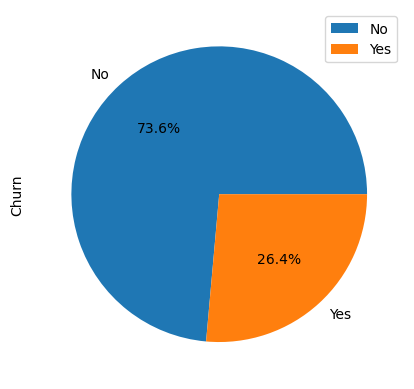

In [103]:
telco_churn_df['Churn'].value_counts().plot(kind='pie', legend=telco_churn_df['Churn'].value_counts, autopct='%1.1f%%', )
plt.show()

From the plot above, we can see that the label are a bit imbalance with not-churn customers on 73.6% and churning customers on 26.4%.  So the prediction result of machine learning's will probably be biased towards not-churn customers.

### Handling Outliers

First, let's see if there's any outliers

<AxesSubplot:xlabel='MonthlyCharges'>

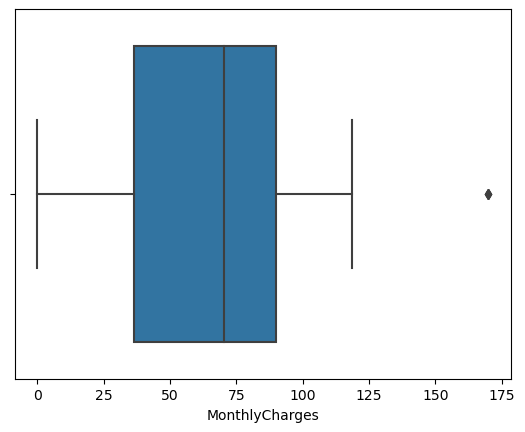

In [104]:
sns.boxplot(x=telco_churn_df['MonthlyCharges'])

<AxesSubplot:xlabel='tenure'>

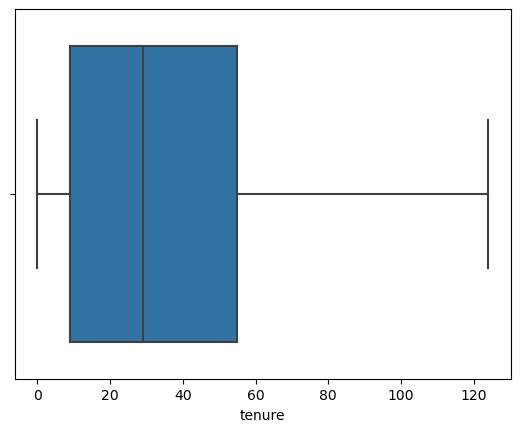

In [105]:
sns.boxplot(x=telco_churn_df['tenure'])

<AxesSubplot:xlabel='TotalCharges'>

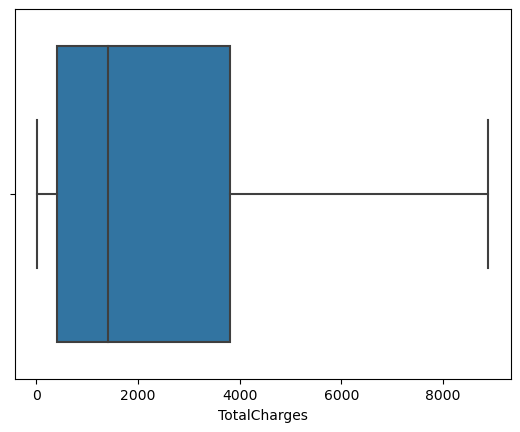

In [106]:
sns.boxplot(x=telco_churn_df['TotalCharges'])

In [107]:
# Use IQR Method to get rid of outliers
Q1 = telco_churn_df.quantile(0.25)
Q3 = telco_churn_df.quantile(0.75)

IQR = Q3 - Q1
telco_churn_df=telco_churn_df[~((telco_churn_df<(Q1-1.5*IQR))|(telco_churn_df>(Q3+1.5*IQR))).any(axis=1)]

# Check if outlier have been dropped
telco_churn_df.shape

(6947, 13)

### Numerical Features Exploratory

In [108]:
# Define column that included numerical value
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

See numerical data distribution based on churn label

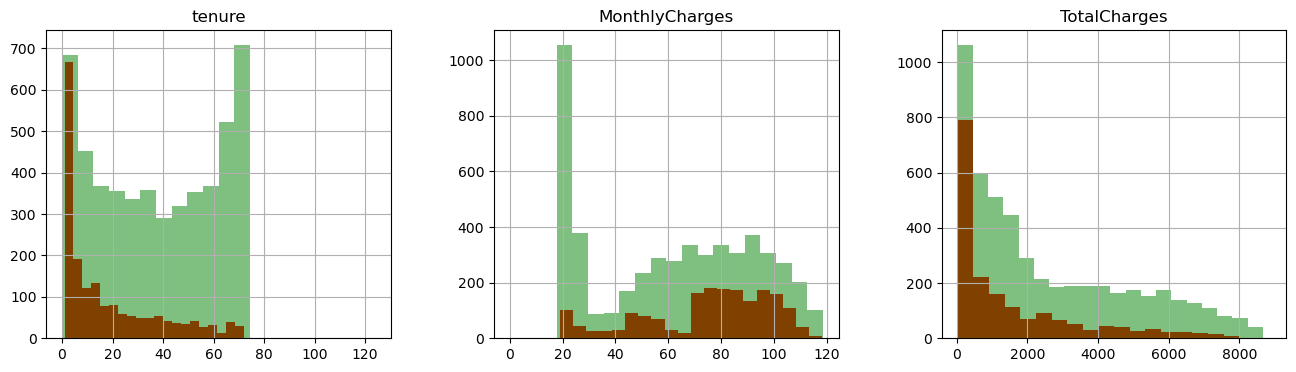

In [109]:
# Plot the two overlaying histogram per each numerical feature, with churning customer and not churn on green.
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
telco_churn_df[telco_churn_df['Churn'] == 'Yes'][numerical_features].hist(bins=20, color='red', ax=ax)
telco_churn_df[telco_churn_df['Churn'] == 'No'][numerical_features].hist(bins=20, color='green', alpha=0.5, ax=ax)
plt.show()

From these histograms we can see that:
1. Churning customer have shorter tenure and lead to the data distribution skewed-right, while not-churning customer have bimodal distribution with the most data have the longest tenure period
2. Most of the not-churning customer paid the cheapest monthly charges on 25$, while most of the churning customer have monthly charges around 75-100$
3. Both of plot on the total charges shows that the data distribution is skewed-right


Next, we want to see correlation between each features

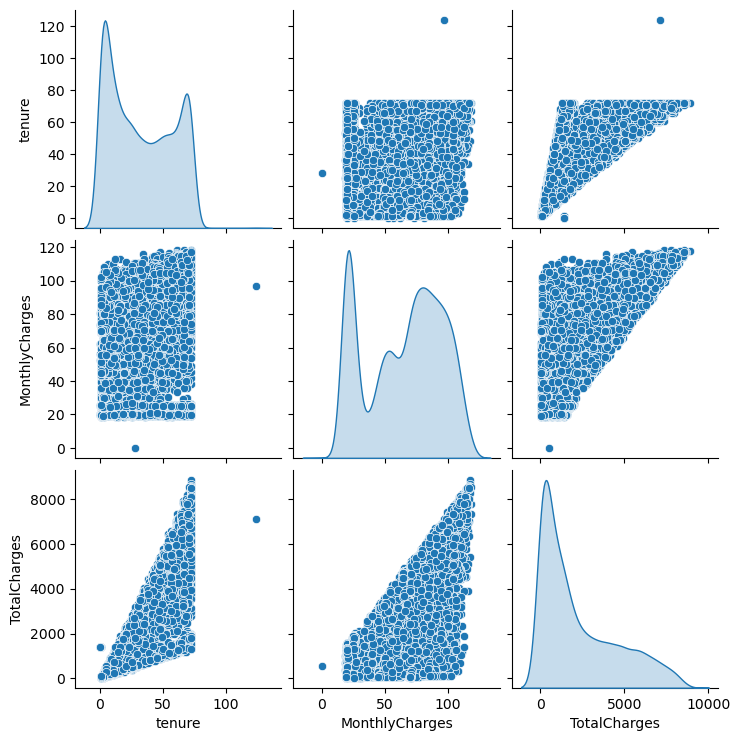

In [111]:
sns.pairplot(telco_churn_df[numerical_features], diag_kind='kde')

From the pairplot above we can see that each of the features made some kind of shape, which show that they have certain value of correlation.  To further evaluate the correlation we can use confusion matrix below.

Text(0.5, 1.0, 'Correlation Matrix for numeric features')

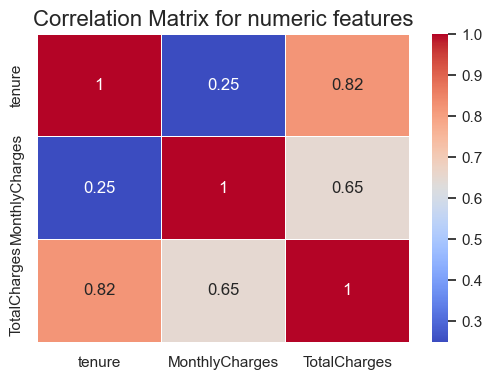

In [231]:
plt.figure(figsize=(6, 4))
correlation_matrix = telco_churn_df[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for numeric features", size=16)

From the correlation above, we can see that each of the variable are tightly correlated with tenure and monthly charges have the least correlation.  But still, we don't have to drop any of the feature or anything.

### Categorical Data Exploratory

In [186]:
# Define column that included categorical value
categorical_features = telco_churn_df.select_dtypes(include='object').columns.tolist()
label = categorical_features[7]

# Remove label from features
categorical_features.pop()
categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'PhoneService',
 'StreamingTV',
 'InternetService',
 'PaperlessBilling']

In [187]:
label

'Churn'

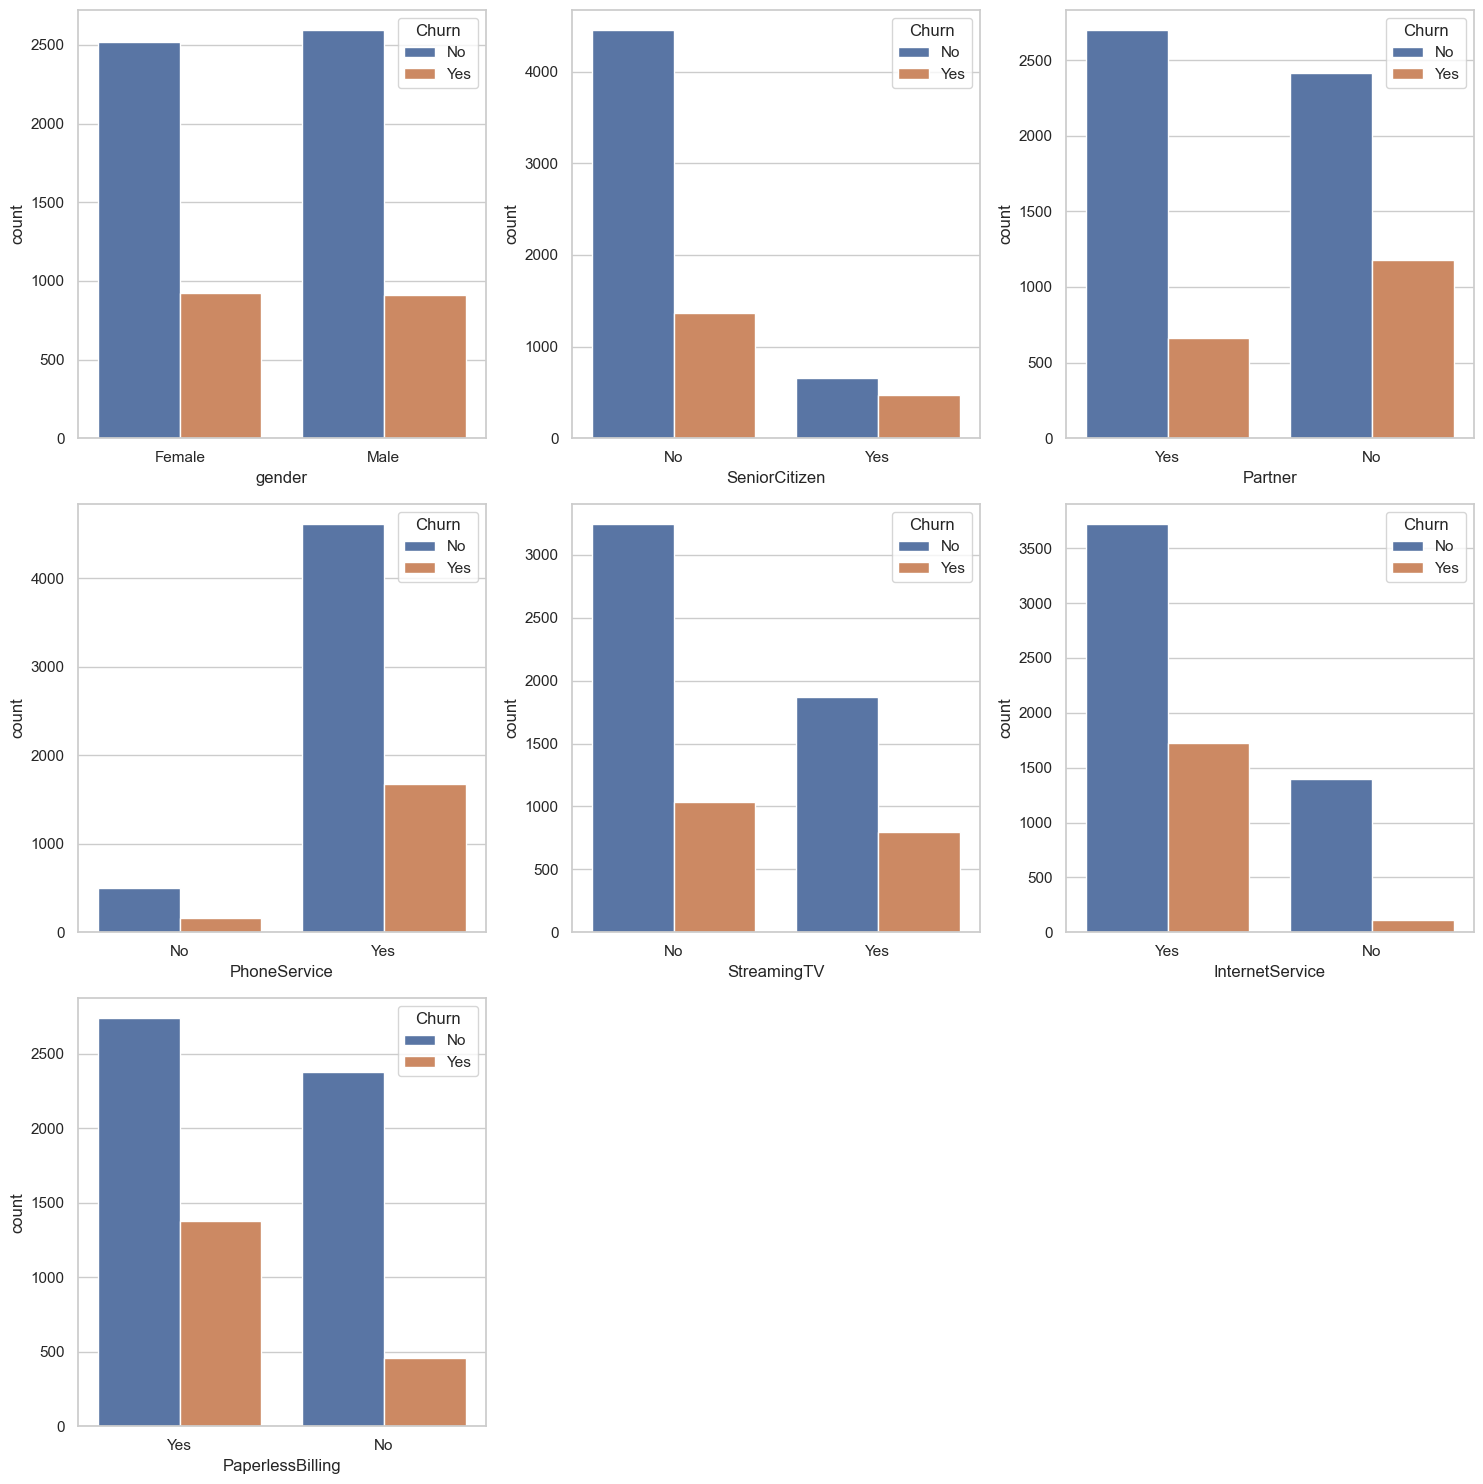

In [276]:
# Define the number of columns and rows for the subplots
sns.set(style='whitegrid')

ncols = 3
nrows = int(np.ceil(len(categorical_features) / ncols))

# Define the figure size
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Flatten the 2-dimensional array of axes
axs = axs.ravel()

# Loop through the categorical features
for i, col in enumerate(categorical_features):
    sns.countplot(data=telco_churn_df, x=col, hue=label, ax=axs[i])

# Remove empty subplots
for i in range(len(categorical_features), nrows * ncols):
    fig.delaxes(axs[i])

# Show the subplots
plt.tight_layout()
plt.show()

From these countplots, we can draw some conclusion:
1. From gender and phone service factor it doesn't seem to impact on whether they churn
2. People who tend to churn are people who don't have partner(partner: No), a senior citizen (SeniorCitizen: yes), people with streaming tv (StreamingTV: yes), people with (InternetService: yes) and people with paperless billing(PaperlessBilling: yes)

## Data Preparation and Feature Engineering

### Delete Unnecesary Columns

In [321]:
cleaned_df = telco_churn_df.drop(columns=['UpdatedAt', 'customerID'])
cleaned_df

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No
...,...,...,...,...,...,...,...,...,...,...,...
6945,Male,No,No,1,Yes,No,Yes,Yes,44.75,44.75,No
6946,Female,Yes,No,1,Yes,No,Yes,Yes,70.15,70.15,Yes
6947,Female,No,No,1,Yes,Yes,Yes,Yes,85.55,85.55,Yes
6948,Female,No,Yes,72,Yes,Yes,Yes,Yes,117.15,8529.50,No


### Label Encoding
In order for machine learning models able to process our data, we need to convert categorical data into numeric with label encoding.  This can be achieved by using sklearn's LabelEncoder()

In [322]:
le = LabelEncoder()
for col in cleaned_df:
    if cleaned_df[col].dtypes == 'object':
        cleaned_df[col] = le.fit_transform(cleaned_df[col])

In [323]:
# We can see that all the object dtype has been converted to numeric
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6947 entries, 0 to 6949
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            6947 non-null   int32  
 1   SeniorCitizen     6947 non-null   int32  
 2   Partner           6947 non-null   int32  
 3   tenure            6947 non-null   int64  
 4   PhoneService      6947 non-null   int32  
 5   StreamingTV       6947 non-null   int32  
 6   InternetService   6947 non-null   int32  
 7   PaperlessBilling  6947 non-null   int32  
 8   MonthlyCharges    6947 non-null   float64
 9   TotalCharges      6947 non-null   float64
 10  Churn             6947 non-null   int32  
dtypes: float64(2), int32(8), int64(1)
memory usage: 692.2 KB


### Feature Selection

Feature selection for categorical features, using Chi-Squared test:

Text(0.5, 1.0, 'Selection of Categorical Features')

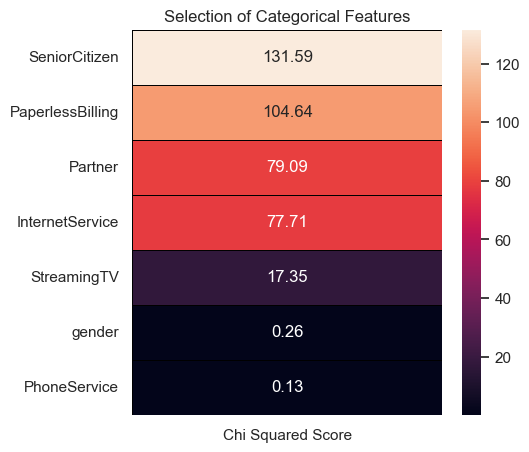

In [326]:
features = cleaned_df.loc[:,categorical_features]
label = cleaned_df['Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features, label)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True, linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Categorical Features')

From the Chi Squared One result above, we can see that gender and PhoneService diplay pretty low correlation (0.x) so we can drop it as well

In [327]:
cleaned_df = cleaned_df.drop(columns=['gender', 'PhoneService'])
cleaned_df.head()

,SeniorCitizen,Partner,tenure,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,0,1,0.008065,0,1,1,0.251686,0.001223,0
1,0,1,0.483871,0,0,1,0.172850,0.133008,0
2,0,0,0.040323,1,1,0,0.877740,0.058951,1
3,0,1,0.580645,1,1,1,0.973862,0.935020,0
4,0,1,0.451613,1,1,0,0.685076,0.518752,0


Feature selection for numerical features, using ANOVA test:

Text(0.5, 1.0, 'Selection of Numerical Features')

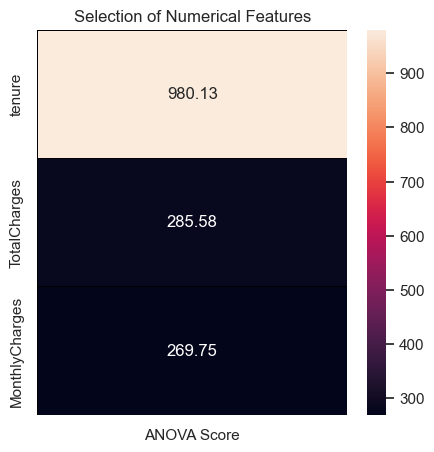

In [334]:
features = cleaned_df.loc[:,numerical_features]
label = cleaned_df.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features, label)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True, linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Numerical Features')

The higher the value of ANOVA Score, the higher the importance of feature.  So based on the above result, we can include all the numerical features

### Normalization
Normalization is done for features whose data does not display normal distribution.  Because the numerical feature such as tenure, MonthlyCharges and TotalCharges displayed a right-skewed and bimodal data distribution, we gonna normalize it using sklearn's MinMaxScaler.

In [324]:
mms = MinMaxScaler()
cleaned_df[numerical_features] = mms.fit_transform(cleaned_df[numerical_features])

In [328]:
cleaned_df.head()

,SeniorCitizen,Partner,tenure,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,0,1,0.008065,0,1,1,0.251686,0.001223,0
1,0,1,0.483871,0,0,1,0.172850,0.133008,0
2,0,0,0.040323,1,1,0,0.877740,0.058951,1
3,0,1,0.580645,1,1,1,0.973862,0.935020,0
4,0,1,0.451613,1,1,0,0.685076,0.518752,0


### Train Test Split

In [329]:
X = cleaned_df.drop(columns='Churn')
y = cleaned_df['Churn']

In [330]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [331]:
# Check each sample of splitted data
print(f'Total # of sample in whole dataset: {len(X)}')
print('=========================================')
print(f'Total # of sample in train dataset: {len(X_train)}')
print('Percentage of train dataset:')
print(y_train.value_counts(normalize=True))
print('=========================================')
print(f'Total # of sample in test dataset: {len(X_test)}')
print('Percentage of test dataset:')
print(y_test.value_counts(normalize=True))

Total # of sample in whole dataset: 6947
Total # of sample in train dataset: 4862
Percentage of train dataset:
0    0.737351
1    0.262649
Name: Churn, dtype: float64
Total # of sample in test dataset: 2085
Percentage of test dataset:
0    0.731894
1    0.268106
Name: Churn, dtype: float64


## Model Building and Evaluation
Because our classification problem are just binary classification, we'll try some simple classification algorithm such as Logistic Regression, Decision Tree, Random Forest, Support Vector Machines, and Naive Bayes Classifier.

In [344]:
# Define function to train models
def train_model(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test, y_pred)))
    plot_roc_curve(classifier, X_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

# Define function to evaluate models
def evaluate_model(classifier, X_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test, classifier.predict(X_test)))

### Logistic Regression Model

In [342]:
lr_model = LogisticRegression()

Cross Validation Score :  81.99%
ROC_AUC Score :  68.29%


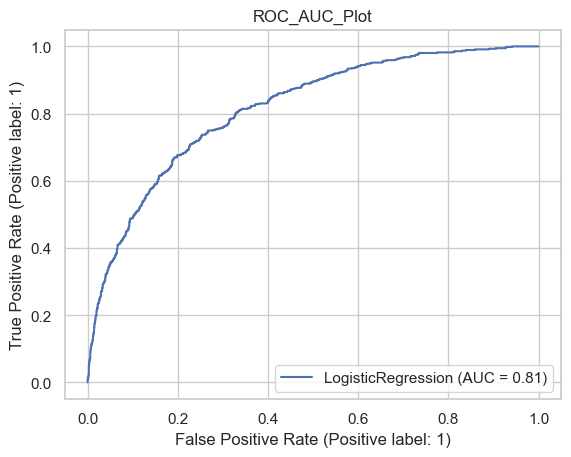

In [343]:
train_model(lr_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1526
           1       0.65      0.46      0.54       559

    accuracy                           0.79      2085
   macro avg       0.73      0.68      0.70      2085
weighted avg       0.77      0.79      0.77      2085



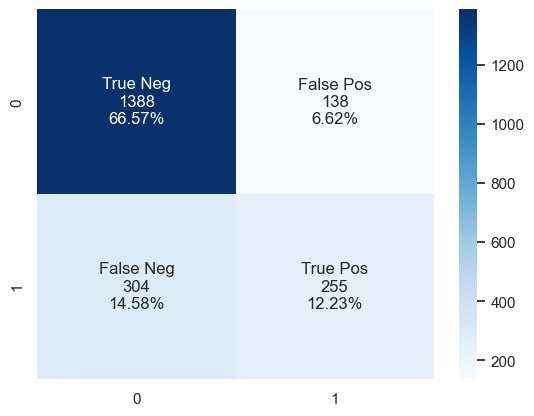

In [345]:
evaluate_model(lr_model, X_test, y_test)

### Decision Tree Model

In [346]:
dt_model = DecisionTreeClassifier(random_state = 42, max_depth = 4, min_samples_leaf = 1)

Cross Validation Score :  80.53%
ROC_AUC Score :  64.68%


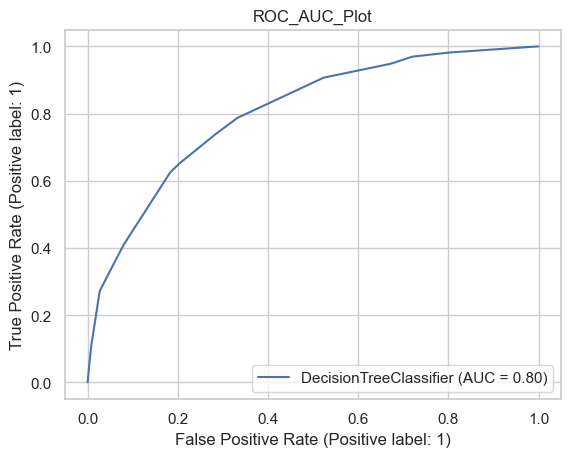

In [348]:
train_model(dt_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1526
           1       0.69      0.35      0.47       559

    accuracy                           0.78      2085
   macro avg       0.75      0.65      0.67      2085
weighted avg       0.77      0.78      0.76      2085



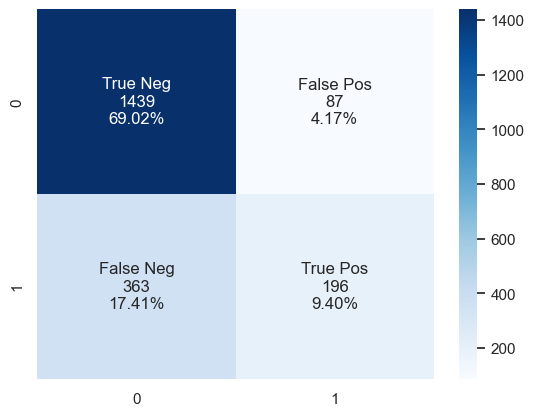

In [349]:
evaluate_model(dt_model, X_test, y_test)

### Random Forest Model

In [350]:
rf_model = RandomForestClassifier(max_depth=4, random_state=0)

Cross Validation Score :  82.43%
ROC_AUC Score :  66.58%


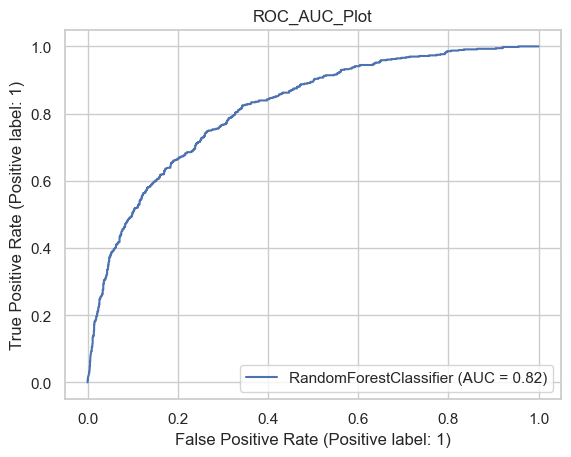

In [351]:
train_model(rf_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1526
           1       0.73      0.38      0.50       559

    accuracy                           0.80      2085
   macro avg       0.77      0.67      0.69      2085
weighted avg       0.79      0.80      0.77      2085



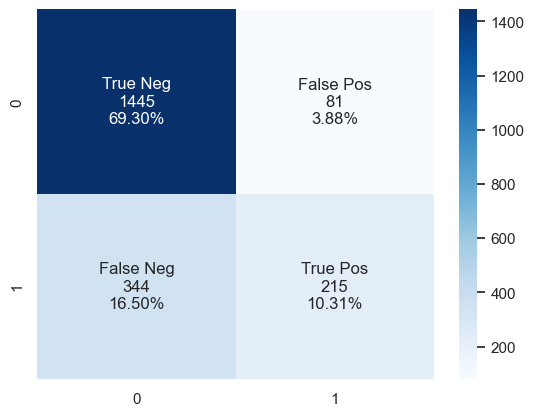

In [352]:
evaluate_model(rf_model, X_test, y_test)

### Support Vector Classifier

In [353]:
svm_model = SVC(random_state=1)

Cross Validation Score :  78.69%
ROC_AUC Score :  66.47%


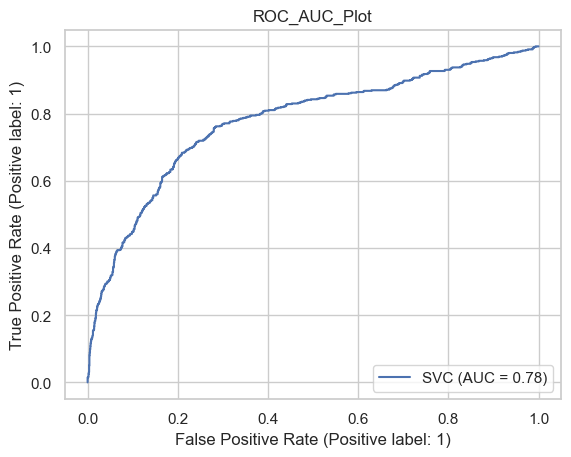

In [354]:
train_model(svm_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1526
           1       0.66      0.41      0.50       559

    accuracy                           0.78      2085
   macro avg       0.73      0.66      0.68      2085
weighted avg       0.77      0.78      0.77      2085



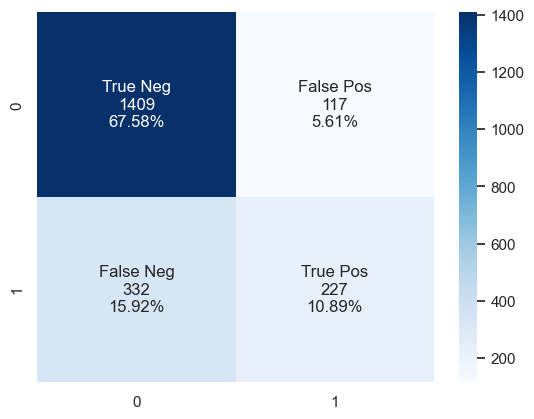

In [356]:
evaluate_model(svm_model, X_test, y_test)

### Naive Bayes Classifier

In [357]:
nb_model = GaussianNB()

Cross Validation Score :  79.25%
ROC_AUC Score :  71.62%


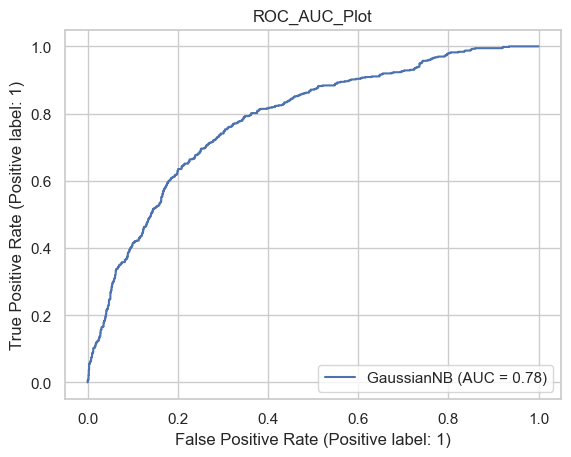

In [359]:
train_model(nb_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1526
           1       0.51      0.67      0.58       559

    accuracy                           0.74      2085
   macro avg       0.69      0.72      0.69      2085
weighted avg       0.77      0.74      0.75      2085



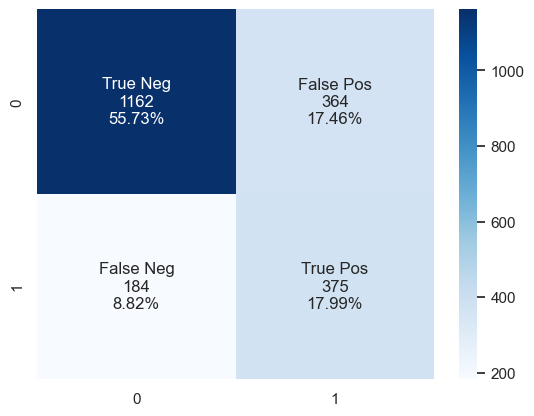

In [360]:
evaluate_model(nb_model, X_test, y_test)